In [1]:
import os
import sys
import os
from PIL import Image,ImageChops,ImageEnhance
def ela_image(path, quality=98):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png' 
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff 
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)  
    return ela_image

In [2]:
Real_image_path='/kaggle/input/casia-dataset/casia/CASIA2/Au/Au_arc_30446.jpg'
Fake_image_path1='../input/casia-dataset/CASIA2/Tp/Tp_D_CND_M_N_ani00018_sec00096_00138.tif'
Fake_image_path2='/kaggle/input/casia-dataset/casia/CASIA1/Sp/Sp_D_NRN_A_sec0047_cha0007_0559.jpg'

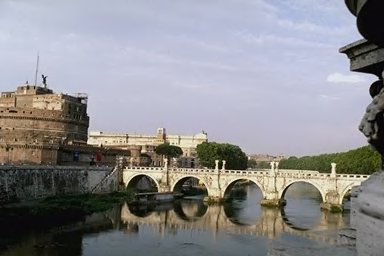

In [3]:
Image.open(Real_image_path)

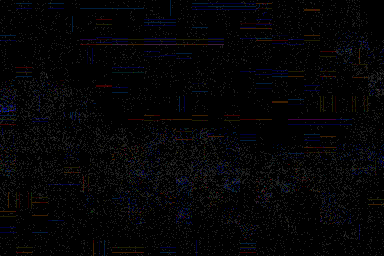

In [4]:
ela_image(Real_image_path)

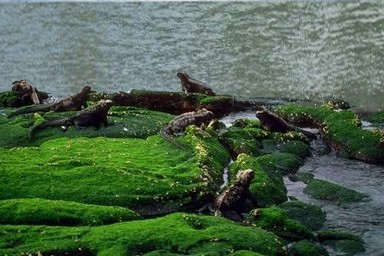

In [5]:
Image.open(Fake_image_path1)

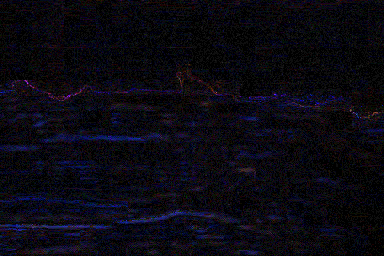

In [6]:
ela_image(Fake_image_path1)

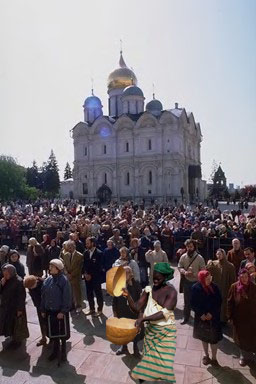

In [7]:
Image.open(Fake_image_path2)

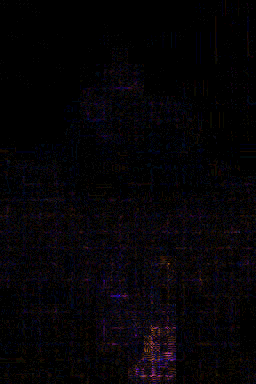

In [8]:
ela_image(Fake_image_path2)

In [9]:
image_size=(128,128)

In [10]:
def preprocessing(image_path):
    return np.array(ela_image(image_path).resize(image_size)).flatten()/255

In [11]:
import numpy as np
preprocessing(Fake_image_path2)

array([0.00392157, 0.00392157, 0.00392157, ..., 0.01960784, 0.01960784,
       0.04705882])

In [12]:
X=[]
Y=[]

In [13]:
import random
path = '/kaggle/input/casia-dataset/CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(preprocessing(full_path))
            Y.append(1)
random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

2100 2100


In [14]:
len(X)

2100

In [15]:
path = '/kaggle/input/casia-dataset/CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(preprocessing(full_path))
            Y.append(0)
print(len(X), len(Y))

4164 4164


In [16]:
from keras.utils.np_utils import to_categorical
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.2,random_state=10)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization

def CNN():
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=(5,5), activation='elu', padding='same', input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))  # Now size is (64, 64, 128)
    
    model.add(Conv2D(filters=128, kernel_size=(5,5), activation='elu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))  # Now size is (32, 32, 128)
    
    model.add(Conv2D(filters=256, kernel_size=(5,5), activation='elu', padding='valid'))  # Now size is (28, 28, 256)
    model.add(MaxPooling2D(pool_size=(2,2)))  # Now size is (14, 14, 256)
    
    model.add(Conv2D(filters=128, kernel_size=(5,5), activation='elu', padding='valid'))  # Now size is (10, 10, 128)
    model.add(AveragePooling2D(pool_size=(2,2)))  # Now size is (5, 5, 128)
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='elu', padding='valid'))  # Reduced kernel size, now size is (3, 3, 64)
    model.add(AveragePooling2D(pool_size=(2,2), padding='same'))  # Ensure size stays valid, now size is (2, 2, 64)
    
    model.add(Flatten())  # Flatten the (2, 2, 64) tensor
    
    model.add(Dense(units=64, activation='elu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Dense(units=16, activation='elu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Dense(units=2, activation='softmax'))  # Final output layer
    
    return model


In [42]:
model1=CNN()
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 128)     9728      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 128)       409728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 256)       819456    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 10, 128)      

In [43]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [44]:
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [45]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.9, 
                                            min_lr=0.00001)

In [46]:
epochs = 30
batch_size = 40
init_lr = 1e-4
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)
model1.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [47]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

In [48]:
# Fit the model
history = model1.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 120, validation_data = (X_val,Y_val),
                               steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,earlystopping])

Epoch 1/120
83/83 [==============================] - 13s 147ms/step - loss: 0.5048 - accuracy: 0.8250 - val_loss: 0.5014 - val_accuracy: 0.8812
Epoch 2/120
83/83 [==============================] - 12s 144ms/step - loss: 0.4112 - accuracy: 0.8918 - val_loss: 0.4542 - val_accuracy: 0.8331
Epoch 3/120
83/83 [==============================] - 12s 149ms/step - loss: 0.3877 - accuracy: 0.9006 - val_loss: 0.3796 - val_accuracy: 0.8571
Epoch 4/120
83/83 [==============================] - 12s 143ms/step - loss: 0.3774 - accuracy: 0.9055 - val_loss: 0.3469 - val_accuracy: 0.8800
Epoch 5/120
83/83 [==============================] - 12s 145ms/step - loss: 0.3580 - accuracy: 0.9149 - val_loss: 0.3089 - val_accuracy: 0.8944
Epoch 6/120
83/83 [==============================] - 12s 143ms/step - loss: 0.3451 - accuracy: 0.9225 - val_loss: 0.2715 - val_accuracy: 0.9112
Epoch 7/120
83/83 [==============================] - 12s 141ms/step - loss: 0.3388 - accuracy: 0.9189 - val_loss: 0.3075 - val_accuracy:

In [49]:
loss,accuracy=model1.evaluate(X_val, Y_val)

27/27 [==============================] - 0s 15ms/step - loss: 0.2247 - accuracy: 0.9220


In [50]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

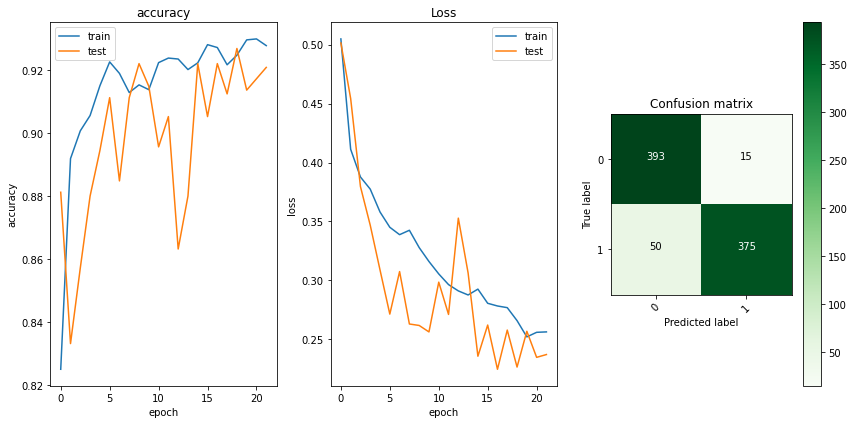

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.subplots(figsize=(12, 6))
plt.subplot(1,3,1) #horizontal,vertical,position
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.subplot(1,3,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.subplot(1,3,3)
Y_pred = model1.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2))
plt.show()

### 

In [ ]:
# VGG16
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# Assuming X and Y are your data and labels
# X = np.array([...])  # Replace with your actual data
# Y = np.array([...])  # Replace with your actual labels

# Split the data
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=10)

# Define the model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Initially freeze all layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='elu'),
    Dropout(0.7),
    BatchNormalization(),
    Dense(64, activation='elu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create an iterator for training
train_iterator = datagen.flow(X_train, Y_train, batch_size=32)

# Validation generator without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
val_iterator = val_datagen.flow(X_val, Y_val, batch_size=32)

# Callbacks
earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    train_iterator,
    epochs=50,
    validation_data=val_iterator,
    steps_per_epoch=X_train.shape[0] // 32,
    callbacks=[reduce_lr, earlystopping, checkpoint]
)

# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True
fine_tune_at = 15  # Choose a layer to


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# Split the data
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=10)

# Define the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Initially freeze all layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.7),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create an iterator for training
train_iterator = datagen.flow(X_train, Y_train, batch_size=32)

# Validation generator without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
val_iterator = val_datagen.flow(X_val, Y_val, batch_size=32)



# Train the model
history = model.fit(
    train_iterator,
    epochs=50,
    validation_data=val_iterator,
    steps_per_epoch=X_train.shape[0] // 32
)

# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True
fine_tune_at = 14  # Choose a layer to fine-tune


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# Assuming X and Y are your data and labels
# X = np.array([...])  # Replace with your actual data
# Y = np.array([...])  # Replace with your actual labels

# Split the data
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=10)

# Load VGG19 instead of VGG16
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Initially freeze all layers

# Define the model with VGG19
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='elu'),
    Dropout(0.7),
    BatchNormalization(),
    Dense(64, activation='elu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')  # Use softmax for multiclass classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create an iterator for training
train_iterator = datagen.flow(X_train, Y_train, batch_size=32)

# Validation generator without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
val_iterator = val_datagen.flow(X_val, Y_val, batch_size=32)

# Callbacks
earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_model_vgg19.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    train_iterator,
    epochs=50,
    validation_data=val_iterator,
    steps_per_epoch=X_train.shape[0] // 32,
    callbacks=[reduce_lr, earlystopping, checkpoint]
)

# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True
fine_tune_at = 15  # Unfreeze from the 15th layer onwards

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model after unfreezing
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine_tune = model.fit(
    train_iterator,
    epochs=20,
    validation_data=val_iterator,
    steps_per_epoch=X_train.shape[0] // 32,
    callbacks=[reduce_lr, earlystopping, checkpoint]
)
